In [22]:
import tensorflow as tf
print("Versión de TensorFlow:", tf.__version__)

Versión de TensorFlow: 2.10.0


In [23]:
#Esto instalará las librerías en tu entorno actual (tf_keras).luego reiniciar kernel
import sys
!{sys.executable} -m pip install scikit-learn matplotlib

In [1]:
!pip install matplotlib

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Oculta avisos de CPU (pero muestra errores reales)
import tensorflow as tf

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import Callback


### Explicaciòn de paràmetros
##### - Ajustar el batch_size 
puede afectar tanto el rendimiento como el uso de memoria: Valores más grandes pueden hacer el entrenamiento más rápido pero requieren más RAM y valores pequeños pueden hacer que el entrenamiento sea más estable pero más lento.
##### - Ajustar epochs
significa que el modelo pasará por todo el conjunto de datos de entrenamiento 20 veces. Más épocas pueden mejorar la precisión, pero también aumentar el riesgo de sobreajuste y menos épocas pueden resultar en un modelo subentrenado.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from sklearn.model_selection import train_test_split

# Función para contar imágenes en una carpeta
def contar_imagenes(ruta_base):
    carpetas = ['NORMAL', 'PNEUMONIA']
    for carpeta in carpetas:
        ruta_completa = os.path.join(ruta_base, carpeta)
        num_imagenes = len(os.listdir(ruta_completa))
        print(f'Carpeta: {os.path.basename(ruta_base)}/{carpeta} - Imágenes: {num_imagenes}')

# Parámetros (ajusta según necesites)
img_width, img_height = 224, 224 # ajusta El tamaño de las imágenes (224x224).
batch_size = 32 #significa que el modelo tomará bloques de 32 imágenes de entrenamiento a la vez para calcular el gradiente y actualizar los pesos.
epochs = 15 #veces que el modelo recorrerá todo el conjunto de entrenamiento

# Rutas
base_path = '/home/variante/ProyectosPython/Proyecto_Neumonia/data/chest_xray'
train_dir = f'{base_path}/train'
val_dir = f'{base_path}/val'
test_dir = f'{base_path}/test'  

# Contar imágenes antes de continuar
print("\nContando imágenes en los conjuntos de datos:")
print("\nConjunto de entrenamiento:")
contar_imagenes(train_dir)
print("\nConjunto de validación:")
contar_imagenes(val_dir)
print("\nConjunto de prueba:")
contar_imagenes(test_dir)




Contando imágenes en los conjuntos de datos:

Conjunto de entrenamiento:
Carpeta: train/NORMAL - Imágenes: 1072
Carpeta: train/PNEUMONIA - Imágenes: 3100

Conjunto de validación:
Carpeta: val/NORMAL - Imágenes: 277
Carpeta: val/PNEUMONIA - Imágenes: 783

Conjunto de prueba:
Carpeta: test/NORMAL - Imágenes: 234
Carpeta: test/PNEUMONIA - Imágenes: 390


 #### imágenes corruptas o anómalas


In [5]:
from PIL import Image

def verificar_imagenes(ruta_base):
    carpetas = ['NORMAL', 'PNEUMONIA']
    num_corruptas = 0
    num_tamanios_anomalos = 0

    for carpeta in carpetas:
        ruta_carpeta = os.path.join(ruta_base, carpeta)
        for archivo in os.listdir(ruta_carpeta):
            ruta_archivo = os.path.join(ruta_carpeta, archivo)
            try:
                img = Image.open(ruta_archivo)
                img.verify()
                img = Image.open(ruta_archivo)
                if img.size != (img_width, img_height):
                    num_tamanios_anomalos += 1
            except (IOError, SyntaxError) as e:
                num_corruptas += 1

    print(f'En {os.path.basename(ruta_base)}: Imágenes corruptas = {num_corruptas}, Tamaños anómalos = {num_tamanios_anomalos}')

# Ejecución
print("\nVerificando imágenes en el conjunto de entrenamiento:")
verificar_imagenes(train_dir)

print("\nVerificando imágenes en el conjunto de validación:")
verificar_imagenes(val_dir)

print("\nVerificando imágenes en el conjunto de prueba:")
verificar_imagenes(test_dir)

#aunque los tamaños sean anomalos se ajustaran para el entrenamiento por el anterior bloque img_width, img_height = 224, 224 y target size abajo


Verificando imágenes en el conjunto de entrenamiento:
En train: Imágenes corruptas = 0, Tamaños anómalos = 4172

Verificando imágenes en el conjunto de validación:
En val: Imágenes corruptas = 0, Tamaños anómalos = 1060

Verificando imágenes en el conjunto de prueba:
En test: Imágenes corruptas = 0, Tamaños anómalos = 624


#### Normalizar
train_datagen, val_datagen, y test_datagen → normalizan los píxeles a [0, 1] con rescale=1./255.

train_generator, val_generator, y test_generator → generan imágenes normalizadas desde las carpetas.

In [6]:
# Normalización de imágenes
# ------------------------------
# Esta sección normaliza los valores de píxeles de las imágenes (de 0–255 a 0–1)
# para que la red neuronal pueda aprender mejor

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores que aplican la normalización al cargar las imágenes
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Para mantener el orden al evaluar
)

Found 4172 images belonging to 2 classes.
Found 1060 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Generadores de Imágenes
Las imágenes crudas (las originales) no siempre son suficientes para entrenar bien una red neuronal. Para mejorar la precisión y evitar que el modelo se quede "pegado" a ciertos patrones, hacemos un par de trucos con las imágenes:

##### Escalado
Convertimos los valores de píxeles (que van de 0 a 255) a un rango entre 0 y 1. Esto lo hacemos dividiendo cada valor de píxel por 255.
Sirve para que el modelo trabaje mejor con los datos.
##### Aumentación de Datos (Data Augmentation)
Generamos imágenes ligeramente diferentes a partir de las originales.

##### ¿Cómo lo hacemos? Aplicando transformaciones aleatorias:
- Rotación: Giramos la imagen hasta 20 grados.
- Desplazamiento horizontal y vertical: Movemos la imagen un 20% en ambas direcciones.
- Cizallamiento: Deformamos la imagen en ángulo.
- Zoom: Acercamos o alejamos la imagen.
- Reflejo horizontal: Volteamos la imagen de izquierda a derecha.
Esto ayuda a que el modelo sea más robusto, evitando que aprenda solo de imágenes en una posición específica.

In [7]:
# Generadores de imágenes

# DATA AUGMENTATION  
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normaliza valores a 0–1
    rotation_range=20,          # Rota imágenes al azar (hasta ±20°)
    width_shift_range=0.2,      # Desplaza horizontal
    height_shift_range=0.2,     # Desplaza vertical
    shear_range=0.2,            # Deforma la imagen diagonalmente
    zoom_range=0.2,             # Aplica zoom aleatorio
    horizontal_flip=True        # Voltea horizontalmente
)


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
     '/home/variante/ProyectosPython/Proyecto_Neumonia/data/chest_xray/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary' #  el tipo de salida (binario), 
)

val_generator = val_datagen.flow_from_directory(
     '/home/variante/ProyectosPython/Proyecto_Neumonia/data/chest_xray/val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)


Found 4172 images belonging to 2 classes.
Found 1060 images belonging to 2 classes.


##### Estructura de la Red (Capas)
Entrada (Conv2D y MaxPooling2D):
Imaginá que tenemos una lupa que recorre la imagen buscando patrones: bordes, manchas, detalles importantes.
El primer filtro (Conv2D) usa 32 lupas (o filtros) que se mueven en cuadraditos de 3x3 píxeles.
Después de "mirar" cada parte, el modelo guarda lo que encontró en una especie de resumen más pequeño (MaxPooling2D).
Esta combinación (conv + pool) se repite 3 veces, pero con más "lupas" en cada paso (32, 64, 128).
##### Normalización (BatchNormalization)
Es como poner todas las imágenes en la misma escala para que el modelo no se confunda si alguna está más brillante o más oscura.
##### Aplanado (Flatten)
Después de detectar patrones, aplastamos toda esa información en una sola línea para poder procesarla mejor.
##### Capa de Neuronas (Dense)
Acá hacemos los cálculos finales.
La capa intermedia (128 neuronas) toma la información ya resumida y trata de encontrar relaciones complejas.
La capa final (3 neuronas con softmax) nos da la probabilidad de que la imagen pertenezca a cada una de las tres clases.
##### Evitar el Sobreajuste (Dropout)
Durante el entrenamiento, algunas neuronas "se apagan" aleatoriamente para evitar que el modelo memorice en vez de aprender.
##### Por qué esta estructura?
Tener varias capas convolucionales ayuda a que la red detecte desde patrones simples (líneas, bordes) hasta patrones complejos (formas específicas).
El dropout evita que el modelo se vuelva flojo y solo aprenda los ejemplos que ya vio.
La última capa usa softmax porque queremos predecir una de tres clases (probabilidades que sumen 1).



##### Cuántas capas tiene el modelo CNN?

1. Conv2D (32 filtros)                     → extracción de características
2. MaxPooling2D                            → reducción de dimensionalidad
3. BatchNormalization                      → estabiliza el entrenamiento

4. Conv2D (64 filtros)                     → más abstracción de características
5. MaxPooling2D
6. BatchNormalization

7. Conv2D (128 filtros)                    → aún más abstracción
8. MaxPooling2D
9. BatchNormalization

10. Flatten                                → aplana los tensores 3D a 1D
11. Dropout                                → reduce sobreajuste
12. Dense (128 neuronas, ReLU)             → capa oculta tradicional
13. Dense (1 neurona, Sigmoid)             → salida para clasificación binaria

🔢 Capas totales: 13 (todas las que definiste en Sequential)

Última capa (output): Dense(1, activation='sigmoid') → adecuada para clasificación binaria

model.summary() muestra: nombre de la capa, tamaño de salida, y cuántos parámetros (pesos + bias) tiene cada una


¿Está normalizando?
Sí, parcialmente:

con BatchNormalization() después de cada capa convolucional, lo cual normaliza las activaciones internas de la red.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras import regularizers



In [12]:
# Modelo CNN
model = Sequential([
    # Primera capa convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),  # 32 filtros de 3x3
    MaxPooling2D((2, 2)),  # Reduce dimensiones a la mitad. Evita sobreajuste
    BatchNormalization(),   # Normaliza las activaciones

    # Segunda capa convolucional (más profunda)
    Conv2D(64, (3, 3), activation='relu'),  # 64 filtros de 3x3
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Tercera capa convolucional (aún más profunda)
    Conv2D(128, (3, 3), activation='relu'),  # 128 filtros de 3x3
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Capas finales (clasificación)
    Flatten(),            # "Aplana" los mapas de características a 1D
    Dropout(0.5),         # Apaga el 50% de neuronas aleatoriamente para evitar sobreajuste
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Capa oculta tradicional
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))  # Salida: 1 neurona (NORMAL vs PNEUMONIA)  #cambiada por que es binaria
])

#BatchNormalization() → ayuda a estabilizar el entrenamiento.
#Dropout(0.5) → reduce sobreajuste apagando conexiones aleatoria
# sumar L2 regularization en las capas Dense, si ves que sigue sobreajustando.

#·COMPILACIÓN INICIAL (con LR por defecto)
model.compile(
    optimizer='adam',       # Algoritmo que ajusta los pesos de la red  # LR por defecto es =0.001
    loss='binary_crossentropy',  # ← CAMBIAR ESTO para clasificación binaria    
    metrics=['accuracy']   # Métrica a monitorear (precisión)
)

#Resumen del modelo
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 111, 111, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                        

### Encontrar la taza de aprendizaje òptima con Learning Rate

In [13]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class LearningRateFinder(Callback):
    def __init__(self, min_lr=1e-6, max_lr=1, steps=100):
        self.min_lr = min_lr #valor mínimo de LR a probar.
        self.max_lr = max_lr #valor máximo de LR a probar.
        self.steps = steps #cantidad de batches donde se probarán LR crecientes.
        # Cálculo del multiplicador para aumentar el LR en cada batch:
        self.lr_mult = (max_lr / min_lr) ** (1 / steps)
        # Para registrar el historial de tasas de aprendizaje y sus respectivas pérdidas:
        self.history = {'lr': [], 'loss': []}
        self.batch_count = 0

    def on_train_batch_begin(self, batch, logs=None): # Este método se ejecuta antes de cada batch durante el entrenamiento.Ajusta el learning rate actual multiplicándolo progresivamente.
        lr = self.min_lr * (self.lr_mult ** self.batch_count) # Calcula el LR actual
        tf.keras.backend.set_value(self.model.optimizer.lr, lr) # Establece el LR al optimizador

        self.history['lr'].append(lr) # Guarda el LR para graficarlo luego
        self.batch_count += 1

    def on_train_batch_end(self, batch, logs=None):#Este método se ejecuta después de cada batch. Guarda el valor de pérdida (loss) para ese batch.
        loss = logs.get('loss')  # Obtiene la pérdida del batch
        self.history['loss'].append(loss)  # Guarda la pérdida

        print(f"Batch {batch}: loss={loss}")  # Muestra por consola el progreso


Batch 0: loss=2.9209372997283936
Batch 1: loss=2.540607452392578........] - ETA: 29:40 - loss: 2.9209 - accuracy: 0.3438
Batch 2: loss=2.2299892902374268.......] - ETA: 18:00 - loss: 2.5406 - accuracy: 0.4062
Batch 3: loss=2.3737826347351074.......] - ETA: 18:12 - loss: 2.2300 - accuracy: 0.4375
Batch 4: loss=2.3077244758605957.......] - ETA: 21:04 - loss: 2.3738 - accuracy: 0.4219
Batch 5: loss=2.264225721359253........] - ETA: 21:08 - loss: 2.3077 - accuracy: 0.4250
Batch 6: loss=2.169635534286499........] - ETA: 20:40 - loss: 2.2642 - accuracy: 0.4375
Batch 7: loss=2.105597734451294........] - ETA: 19:56 - loss: 2.1696 - accuracy: 0.4464
Batch 8: loss=1.998604416847229........] - ETA: 19:41 - loss: 2.1056 - accuracy: 0.4609
Batch 9: loss=1.942941665649414........] - ETA: 19:38 - loss: 1.9986 - accuracy: 0.4896
Batch 10: loss=1.9080493450164795......] - ETA: 19:47 - loss: 1.9429 - accuracy: 0.5000
Batch 11: loss=1.8610925674438477......] - ETA: 19:40 - loss: 1.9080 - accuracy: 0.4972

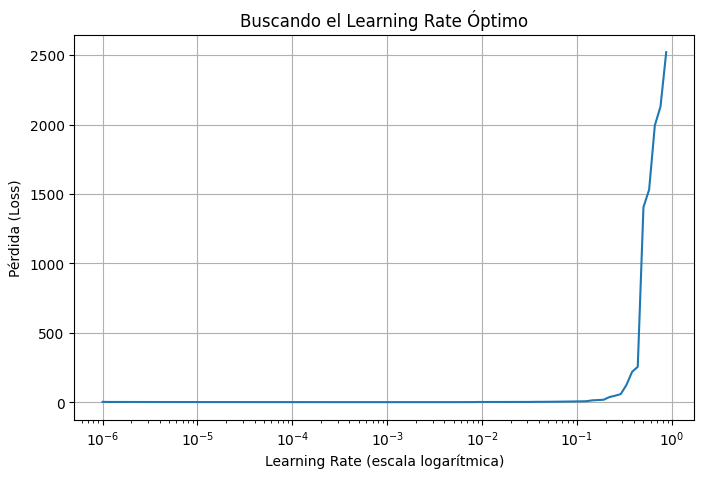

In [14]:
# Sacamos un batch del generador
X_batch, y_batch = next(train_generator)

# Instanciamos el callback para buscar el mejor learning rate
lr_finder = LearningRateFinder(min_lr=1e-6, max_lr=1, steps=100)

# Recompilamos el modelo (esto reinicia el optimizador)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Definimos los pesos por clase para balancear el entrenamiento
class_weight = {
    0: 3.0,  # NORMAL (menos imágenes → más peso)
    1: 1.0   # PNEUMONIA (más imágenes → menos peso)
}

# Entrenamos con ese batch repetido para probar distintos learning rates
model.fit(
    train_generator,              # Generador, no datos fijos
    steps_per_epoch=100,
    epochs=1,
    callbacks=[lr_finder],
    verbose=1,
    class_weight=class_weight     # Aplica el balanceo de clases
)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(lr_finder.history['lr'], lr_finder.history['loss'])
plt.xscale('log')
plt.xlabel("Learning Rate (escala logarítmica)")
plt.ylabel("Pérdida (Loss)")
plt.title("Buscando el Learning Rate Óptimo")
plt.grid(True)
plt.show()


In [16]:
#Prueba de punto óptimo 1: 0.001 
#prueba 2: 0.03
#prueba 3: 0.003
#Prueba 4: 0.005
#Estabecer el LR óptimo en tu optimizador:

from tensorflow.keras.optimizers import Adam

optimal_lr = 0.005  
optimizer = Adam(learning_rate=optimal_lr)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',  # ← cambio necesario para clasificación binaria
    metrics=['accuracy']
)


| Paso siguiente:    | Acción principal                             |
| ------------------ | -------------------------------------------- |
| Entrenamiento      | Con el LR óptimo que encontraste             |
| Guardar modelo     | `model.save('modelo.h5')`                    |
| Cargar modelo      | `load_model('modelo.h5')`                    |
| Evaluar modelo     | Usando `evaluate()` en el conjunto de prueba |
| Hacer predicciones | Con `predict()` sobre nuevas imágenes        |


In [17]:
#Entrenar el modelo completo ahora con ese LR
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,  # las vueltas que les da.
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1
)
#Esos valores indican cómo se está desempeñando el modelo en datos de validación
#(no vistos durante el entrenamiento), lo que te ayuda a saber si se está sobreajustando o no.

Epoch 1/15
131/131 [==============================] - 1449s 11s/step - loss: 19817.8633 - accuracy: 0.4408 - val_loss: 443931.2188 - val_accuracy: 0.3575
Epoch 2/15
131/131 [==============================] - 1289s 10s/step - loss: 10686.1660 - accuracy: 0.2629 - val_loss: 7853.8438 - val_accuracy: 0.2623
Epoch 3/15
131/131 [==============================] - 1606s 12s/step - loss: 5989.8530 - accuracy: 0.2744 - val_loss: 4441.0845 - val_accuracy: 0.7387
Epoch 4/15
131/131 [==============================] - 1558s 12s/step - loss: 3426.3008 - accuracy: 0.7430 - val_loss: 2575.6887 - val_accuracy: 0.7387
Epoch 5/15
131/131 [==============================] - 1273s 10s/step - loss: 2017.6132 - accuracy: 0.7387 - val_loss: 1556.6519 - val_accuracy: 0.7387
Epoch 6/15
131/131 [==============================] - 1214s 9s/step - loss: 1248.8221 - accuracy: 0.7430 - val_loss: 989.7808 - val_accuracy: 0.7387
Epoch 7/15
131/131 [==============================] - 1284s 10s/step - loss: 814.5472 - accu

In [18]:
# Guardar el modelo completo para no tener que volver a entrenar cada vez:  (arquitectura + pesos + configuración)
model.save('modelo_neumonia.h5')


In [19]:
#Cargar el modelo guardado (cuando lo necesite para predecir o evaluars)
from tensorflow.keras.models import load_model

modelo_cargado = load_model('modelo_neumonia.h5')


#### Evaluar el modelo con el conjunto de prueba


In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/home/variante/ProyectosPython/Proyecto_Neumonia/data/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = modelo_cargado.evaluate(test_generator)
print(f'🔍 Precisión en el conjunto de prueba: {accuracy:.2f}')

Found 624 images belonging to 2 classes.
20/20 [==============================] - 56s 2s/step - loss: 73.1620 - accuracy: 0.5000
🔍 Precisión en el conjunto de prueba: 0.50


#### Hacer predicciones
Para obtener la clase predicha en nuevas imágenes:

1/1 [==============================] - 17s 17s/step
Predicción: NORMAL
Clases del generador: {'NORMAL': 0, 'PNEUMONIA': 1}
34/34 [==============================] - 93s 3s/step
Clasificación completa:


/home/variante/miniconda3/envs/tf_keras/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/variante/miniconda3/envs/tf_keras/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/variante/miniconda3/envs/tf_keras/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

              precision    recall  f1-score   support

      NORMAL       0.26      1.00      0.41       277
   PNEUMONIA       0.00      0.00      0.00       783

    accuracy                           0.26      1060
   macro avg       0.13      0.50      0.21      1060
weighted avg       0.07      0.26      0.11      1060



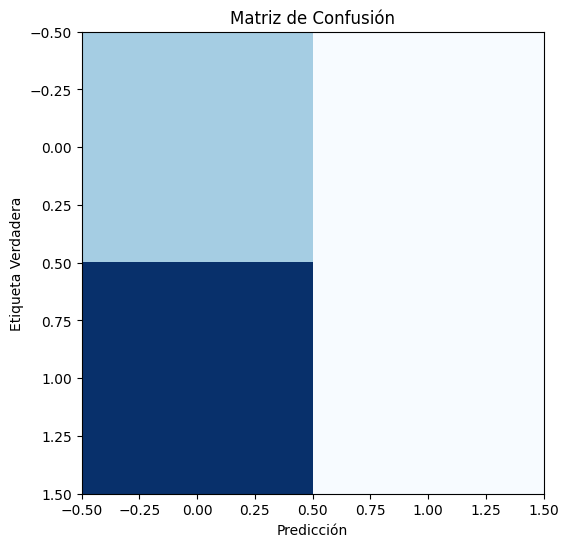

In [21]:
# Predicción de una imagen nueva
img = load_img('/home/variante/ProyectosPython/Proyecto_Neumonia/data/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg', target_size=(img_width, img_height))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
predicted_label = list(val_generator.class_indices.keys())[predicted_class]
print(f"Predicción: {predicted_label}")

# Verificar clases del generador
print("Clases del generador:", val_generator.class_indices)

# Evaluación detallada
y_pred = np.argmax(model.predict(val_generator), axis=1)
y_true = val_generator.classes

print("Clasificación completa:")
class_names = [label for label, _ in sorted(val_generator.class_indices.items(), key=lambda x: x[1])]
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()
